This project was created as part of the University of Washington Data Science Certificate program. The course curriculum is designed to provide the analytical skills and technical ability to build a data science pipeline, explore and visualize data in large data sets, use advanced statistical techniques in data analysis and interpretation, and construct machine learning models.

For this project, I chose the Internet Advertisements dataset in which tht  task is to predict whether an image is an advertisement ("ad") or not ("nonad"). (very large data set)

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import *
from sklearn.metrics import *

In [44]:
%matplotlib inline

### Access data ###

To get started we need to access the Internet Advertisements Data Set from the UCL ML repo here: https://archive.ics.uci.edu/ml/datasets/Internet+Advertisements

The internet advertisement data folder contains two files:'ad.data', which contains attributes and class data as well as 'ad.names', which contains header names for the attributes. 

These two data sets need to be combined in order to give us a complete data set in which to build the predictive model.

First, we take the 'ad.data' data set from the url and and load it into a pandas dataframe.

In [45]:
#assign url as string where we will pull data from
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/internet_ads/ad.data"

#pull down the csv file into a pandas dataframe
ad_df = pd.read_csv(url, header=None, dtype=None, low_memory=False)

To get a quick view of the data we'll use .head() function to preview the first 5 rows of data.

In [46]:
ad_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


Next, we need to add meaningful column headers. Since we set 'None' to the header argument above (header='None') the columns have default integer column names. To get column names we'll download the 'ad.names' data set.

Instead of pulling the data directly into a dataframe as we did above, we will assign the url to a variable and use the request.get() function to pull and store the non-CSV data as a requests object. As a requests object we can then easily parse information from the scraped html using the BeatifulSoup package.

In [47]:
#assign url where we will pull data from for column names
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/internet_ads/ad.names"

#use requests to get url and store information as requests object
response = requests.get(url)

# use BeautifulSoup on content object to pull out relevant content
#lxml = type of html format we are working with
#.text = Get all the child strings and return concatenated using the given separator
#.split('\n') = given separator
soup = BeautifulSoup(response.content, "lxml").text.split('\n')

In [48]:
#print(soup)

To easily view and clean the scraped data we'll create a single column dataframe with a name attribute "header".

In [49]:
ad_names = pd.DataFrame({'header':soup})
print (ad_names)

                                                 header
0     | "w:\c4.5\alladA" names file -- automatically...
1                                                      
2                                  ad, nonad | classes.
3                                                      
4                                   height: continuous.
5                                    width: continuous.
6                                   aratio: continuous.
7                                           local: 0,1.
8                         | 457 features from url terms
9                              url*images+buttons: 0,1.
10                             url*likesbooks.com: 0,1.
11                              url*www.slake.com: 0,1.
12                             url*hydrogeologist: 0,1.
13                                        url*oso: 0,1.
14                                      url*media: 0,1.
15                               url*peace+images: 0,1.
16                                  url*blipvert

As you can see from the output above the header values have a number of issues we need to clean up, including: 
1. Feature terms - we know from the data set description we have 5 groups of feature terms - url, origurl, ancurl, alt, and caption. The data set has rows with the terms names which divide the the data set.
2. Empty rows
3. Binary attribute rows contain "0"s and "1"s indicating the possible attribute value.
4. Various characters (ex. "*" "," ".") - many of the attributes contain characters which we need to remove in order to have a clean header set. 

To clean up the header we'll create a function called "clean_header", which will take each row as an input and apply a series of strings methods. 

First, we'll remove all characters after ":" to separate the header from the potential values listed, "1" or "0".

Second, we see feature terms are identified by a vertical bar "|" in the data. We'll use this to identify and remove these values.

Third, we'll replace characters "*" and "+" with "_" to improve readability. 

In [50]:
#clean up the values in the column
def clean_header(row):
     return str(row.split(":")[0].split("|")[0].replace("*","_").replace("+","_").strip())      

#save cleaned ad_names
ad_names['header'] = ad_names['header'].apply(clean_header)

To check the output of our function, I'll once again call the .head() function; however, this time I'll include (10) in order to see the first 10 rows. 

In [51]:
ad_names.head(10)

,header
0,
1,
2,"ad, nonad"
3,
4,height
5,width
6,aratio
7,local
8,
9,url_images_buttons


Now that we've cleaned up the header values, we now need to deal with empty cells. 

To determine how to best handle these we'll first check to see if they contain null values to drop or are empty strings. To do this we'll use the isnull() function on header values.

In [52]:
#check to see if empty strings?
ad_names['header'].isnull().sum()

0

Since there are zero null values, we'll convert the empty strings to NaN objects using replace() and then call dropna() on the DataFrame to delete rows with null tenants.

In [53]:
#replace nan
ad_names['header'].replace('', np.nan, inplace=True)

#drop nan
ad_names.dropna(subset=['header'], inplace=True)

#reset index
ad_names = ad_names.reset_index(drop=True)

In [54]:
ad_names.head()

,header
0,"ad, nonad"
1,height
2,width
3,aratio
4,local


From the 'ad.data' data set above we see that the target variable (ad, nonad) is the last column of data; however, it appears as the first value in this header list. We'll remove this and add it to the end of the header column.

In [55]:
#drop first row
ad_names = ad_names.drop([0])

#reset index
ad_names = ad_names.reset_index(drop=True)

#assign value
ad_names.at[1558,'header'] = 'ad, nonad'

Now that we have a complete list of column headers we need to apply them to the data set.

We'll turn our single column dataframe into a list then assign the list as column names, replacing the default integers (0-1558).

In [56]:
#create a column name list
ad_columns = ad_names["header"].tolist()

#assign column names to dataframe
ad_df.columns = ad_columns

Now that we've combined the data set with the column headers into a single table we can begin exploring and preparing the data. 

## Exploratory Data Analysis and Data Prep

Through iterative exploration and preparation we'll identify and replace outliers, change data types, and deal with null and missing values.

To prepare the data set we're going to first determine the data types, determine what the appropriate data type should be, and coerce them to numeric, if necessary.

We won't be able to determine data types just by looking at the data. For example, see the first 5 rows below. All of the columns look numeric; however, we need to confirm they are before we can start using them for our modeling.

In [57]:
ad_df.head()

,height,width,aratio,local,url_images_buttons,url_likesbooks.com,url_www.slake.com,url_hydrogeologist,url_oso,url_media,...,caption_home,caption_my,caption_your,caption_in,caption_bytes,caption_here,caption_click,caption_for,caption_you,"ad, nonad"
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


By using dtypes.value_counts() we can quickly determine what data types we have and how many.

In [58]:
#count data types
ad_df.dtypes.value_counts()

int64     1554
object       5
dtype: int64

The data set description from the UCL ML repo stated that of the 1558 attributes, 3 are continous while all others binary.

Since we expected only 1 of the 1559 columns (which includes +1 column for the target variable "ad, nonad") to contain an object data type, we need to find out which four attributes are objects so that we can coerce them to numeric.

To do this we'll use .select_dtypes() on the columns to return a subset of the dataFrame’s columns which are objects. 

In [59]:
ad_df.select_dtypes(include='object').columns

Index(['height', 'width', 'aratio', 'local', 'ad, nonad'], dtype='object')

While the three continuous attributes ('height', 'width', 'aratio') are expected to be numeric they are most likely listed as 'object' due to the missing values. The data set description stated, "One or more of the three continous features are missing in 28% of the instances".

In addition to 'height', 'width', and 'aratio', the 'local' column is also listed as object datatype. To understand why we'll use .unique() to see the values used in this column which will help determine why it is appearing as an object.

In [60]:
print(ad_df.loc[:,"local"].unique())

['1' '0' '?']


The placeholder '?' is causing this column to appear as an 'object' data type. For this and the three attributes which are supposed to be continuous we're going to replace the missing values and ensure they are numeric. 

First, we'll create the non-numeric values using the pd.to_numeric function, then replace those nan values with imputed values from the dataset

In [61]:
# Coerce data type to numeric
# errors='coerce' tells function to turn string into nan if it cannot be turned into a number
ad_df.loc[:, "height"] = pd.to_numeric(ad_df.loc[:, "height"], errors='coerce')
ad_df.loc[:, "width"] = pd.to_numeric(ad_df.loc[:, "width"], errors='coerce')
ad_df.loc[:, "aratio"] = pd.to_numeric(ad_df.loc[:, "aratio"], errors='coerce')
ad_df.loc[:, "local"] = pd.to_numeric(ad_df.loc[:, "local"], errors='coerce')

#Determine the location of nans
HasNanH = np.isnan(ad_df.loc[:,"height"])
HasNanW = np.isnan(ad_df.loc[:,"width"])
HasNanA = np.isnan(ad_df.loc[:,"aratio"])
HasNanL = np.isnan(ad_df.loc[:,"local"])

#impute median from valumn and apply to nan vlaues
ad_df.loc[HasNanH, "height"] = np.nanmedian(ad_df.loc[:,"height"])
ad_df.loc[HasNanW, "width"] = np.nanmedian(ad_df.loc[:,"width"])
ad_df.loc[HasNanA, "aratio"] = np.nanmedian(ad_df.loc[:,"aratio"])
ad_df.loc[HasNanL, "local"] = np.nanmedian(ad_df.loc[:,"local"])

In [62]:
#check data type counts
ad_df.dtypes.value_counts()

int64      1554
float64       4
object        1
dtype: int64

Now that we have the correct data types we'll visualize the data using a histogram to understand the overview of the numeric distribution.

(array([2.496e+03, 5.100e+02, 2.020e+02, 4.700e+01, 1.100e+01, 9.000e+00,
        0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([  1. ,  64.9, 128.8, 192.7, 256.6, 320.5, 384.4, 448.3, 512.2,
        576.1, 640. ]),
 <a list of 10 Patch objects>)

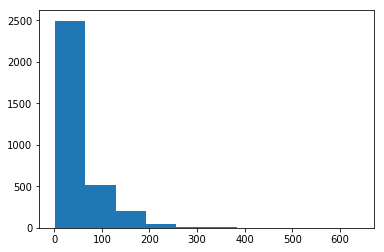

In [63]:
plt.hist(ad_df.loc[:, "height"])

(array([4.640e+02, 1.849e+03, 3.890e+02, 2.540e+02, 3.500e+01, 1.800e+01,
        3.900e+01, 2.040e+02, 1.000e+00, 2.600e+01]),
 array([  1. ,  64.9, 128.8, 192.7, 256.6, 320.5, 384.4, 448.3, 512.2,
        576.1, 640. ]),
 <a list of 10 Patch objects>)

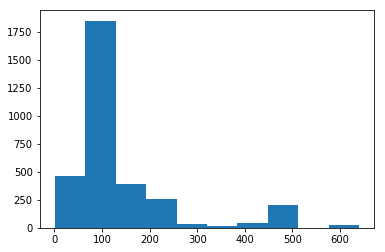

In [64]:
plt.hist(ad_df.loc[:, "width"])

(array([2.765e+03, 4.810e+02, 4.000e+00, 5.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+01]),
 array([1.500000e-03, 6.001350e+00, 1.200120e+01, 1.800105e+01,
        2.400090e+01, 3.000075e+01, 3.600060e+01, 4.200045e+01,
        4.800030e+01, 5.400015e+01, 6.000000e+01]),
 <a list of 10 Patch objects>)

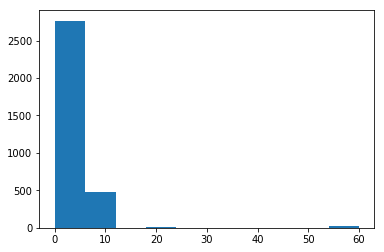

In [65]:
plt.hist(ad_df.loc[:, "aratio"])

The concentrated data points with extreme values in these histograms indicate that we may have outliers at the high end of these distributions. 

To remove these we'll create a high limit which is 2 standard deviations from the mean. This will then allow us to determine which values are greater than the limit and then replace them with the limit.

In [66]:
## The high limit for acceptable values is the mean plus 2 standard deviations
LimitHiH = ad_df.loc[:, "height"].mean() + 2*(ad_df.loc[:, "height"].std())
LimitHiW = ad_df.loc[:, "width"].mean() + 2*(ad_df.loc[:, "width"].std())
LimitHiA = ad_df.loc[:, "aratio"].mean() + 2*(ad_df.loc[:, "aratio"].std())

#Find which values are greater than the high limit
TooHighH = ad_df.loc[:, "height"] > LimitHiH
TooHighW = ad_df.loc[:, "width"] > LimitHiW
TooHighA = ad_df.loc[:, "aratio"] > LimitHiA

#Replace values with the limit
ad_df.loc[TooHighH, "height"] = LimitHiH
ad_df.loc[TooHighW, "width"] = LimitHiW
ad_df.loc[TooHighA, "aratio"] = LimitHiA

Now we'll check how the removal of outliers has impacted the distributions 

(array([ 369.,  424.,  324., 1359.,  137.,  140.,  130.,   84.,   84.,
         228.]), array([  1.        ,  16.35651412,  31.71302824,  47.06954236,
         62.42605648,  77.7825706 ,  93.13908472, 108.49559884,
        123.85211297, 139.20862709, 154.56514121]), <a list of 10 Patch objects>)

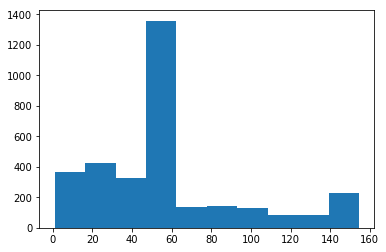

In [67]:
plt.hist(ad_df.loc[:, "height"])

(array([ 228.,  296., 1599.,  353.,  212.,  150.,  119.,   26.,   13.,
         283.]), array([  1.        ,  37.70141954,  74.40283908, 111.10425863,
        147.80567817, 184.50709771, 221.20851725, 257.90993679,
        294.61135634, 331.31277588, 368.01419542]), <a list of 10 Patch objects>)

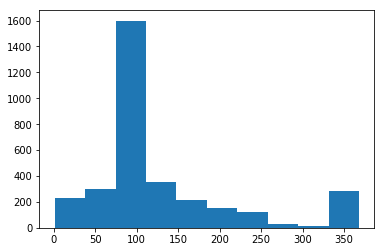

In [68]:
plt.hist(ad_df.loc[:, "width"])

(array([9.08e+02, 1.32e+03, 2.87e+02, 2.13e+02, 8.70e+01, 2.84e+02,
        1.21e+02, 2.50e+01, 1.00e+00, 3.30e+01]),
 array([1.50000000e-03, 1.38225915e+00, 2.76301830e+00, 4.14377745e+00,
        5.52453660e+00, 6.90529575e+00, 8.28605490e+00, 9.66681405e+00,
        1.10475732e+01, 1.24283323e+01, 1.38090915e+01]),
 <a list of 10 Patch objects>)

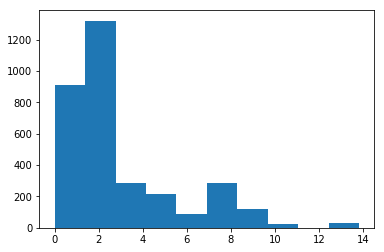

In [69]:
plt.hist(ad_df.loc[:, "aratio"])

In [70]:
ad_df.head()

,height,width,aratio,local,url_images_buttons,url_likesbooks.com,url_www.slake.com,url_hydrogeologist,url_oso,url_media,...,caption_home,caption_my,caption_your,caption_in,caption_bytes,caption_here,caption_click,caption_for,caption_you,"ad, nonad"
0,125.0,125.000000,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57.0,368.014195,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33.0,230.000000,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60.0,368.014195,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60.0,368.014195,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


Now that we've replaced missing values and removed outliers from our attributes data, we're going to create a new numeric column for the target variable.

We'll begin by confirming we don't have any missing values

In [71]:
#check values of 'ad, nonad' column
ad_df.loc[:,"ad, nonad"].unique()

array(['ad.', 'nonad.'], dtype=object)

In [72]:
ad_df.head()

,height,width,aratio,local,url_images_buttons,url_likesbooks.com,url_www.slake.com,url_hydrogeologist,url_oso,url_media,...,caption_home,caption_my,caption_your,caption_in,caption_bytes,caption_here,caption_click,caption_for,caption_you,"ad, nonad"
0,125.0,125.000000,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57.0,368.014195,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33.0,230.000000,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60.0,368.014195,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60.0,368.014195,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.


In [73]:
# plot the counts for each category
#ad_df.loc[:,"ad, nonad"].value_counts().plot(kind='bar')

Then we'll create a new numeric column from the categorical 'ad, nonad' column which will be our target variable.

In [74]:
#create new numeric column for ad
ad_df.loc[:,"ad"] = (ad_df.loc[:,"ad, nonad"] == "ad.").astype(int)

Next, we'll drop the 'ad, nonad' column as it is no longer necessary.

In [75]:
# Remove column "ad, nonad"
ad_df = ad_df.drop("ad, nonad", axis=1)

In [76]:
ad_df.head()

,height,width,aratio,local,url_images_buttons,url_likesbooks.com,url_www.slake.com,url_hydrogeologist,url_oso,url_media,...,caption_home,caption_my,caption_your,caption_in,caption_bytes,caption_here,caption_click,caption_for,caption_you,ad
0,125.0,125.000000,1.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,57.0,368.014195,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,33.0,230.000000,6.9696,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,60.0,368.014195,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,60.0,368.014195,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Standardization
Before we create our predictive model, we're going to standardize our variables in order to use all of them in tandem without letting different scales distort the signal they contain.

To do this we'll apply a method called Z-normalization (aka standardization). Z-normalization changes the variable so that it’s mean is equal to 0.0 and its standard dev is equal to 1.0

In [77]:
#columns to be standardized
p = ad_df[['height','width','aratio']]

In [78]:
#create scaler object
standardization_scale = StandardScaler()#.fit(p)

In [79]:
#apply scaler to variables
z = standardization_scale.fit_transform(p)

In [80]:
z

array([[ 1.81726493, -0.10648065, -0.80411874],
       [-0.02592535,  2.67243541,  1.96734969],
       [-0.6764631 ,  1.09421541,  1.49039037],
       ...,
       [-0.94752049, -0.16365665,  0.81686646],
       [-0.18855979, -0.27800865, -0.38054781],
       [-0.48672292, -1.07847269, -0.80411874]])

In [81]:
hc_scaled = pd.DataFrame(z)

In [82]:
ad_df[['height','width','aratio']] = hc_scaled

ad_df.head()

### Export data
Lastly, we'll export our data which is ready to be modeled.

In [83]:
#dataframe to csv
ad_df.to_csv('InternetAd_Dataset.csv', index=None)

### Data Modeling

Now that we have our feature set we're going to create a binary classification model to make our ad/nonad prediction. 

First, we'll split the dataset into train and test sets. The split allows us to avoid overfitting the model. We'll follow the standard a 80% train /20% test data split.

Next, we'll use the data to train and test three classifiers: Logistic Regression, Naive Bayes, and K Nearest Neighbor.

Lastly, we'll evaluate these models using Confusion matrix and ROC curve 

### Train/Test

To start, we will use pandas to import the feature set we previously created

In [84]:
#Read csv into a pandas dataframe
ad_df = pd.read_csv('InternetAd_Dataset.csv')

Then we will split the data into 1) labels - what we want to predict (in this case, ads) and 2) inputs (features) - the data used to predict the labels. 

In [85]:
#Assign 'ad' column to y
y = ad_df.ad

#Create feature set which excludes the 'ad'
X = ad_df.drop('ad', axis=1)

To easily split the dataset into a training set and testing set, we'll import the train_test_split() function from sklearn.

In [89]:
from sklearn.model_selection import train_test_split

For the train_test_split() function, we will pass the variables X and y that we obtained previously, along with test_size=0.20 which is used to indicate that the test data should be 20% of the total data and rest 80% should be train data.

In [90]:
X, XX, Y, YY = train_test_split(X, y, test_size=0.2)
#print(X_train)
#print(X_train.head())
# print(X_train.shape)
# print(X_test)
# print(X_test.head())
# print(X_test.shape)

In [91]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [92]:
""" CLASSIFICATION MODELS """
# Logistic regression classifier
# print ('\n\n\nLogistic regression classifier\n')
# C_parameter = 50. / len(X) # parameter for regularization of the model
# class_parameter = 'ovr' # parameter for dealing with multiple classes
# penalty_parameter = 'l1' # parameter for the optimizer (solver) in the function
# solver_parameter = 'saga' # optimization system used
# tolerance_parameter = 0.1 # termination parameter

' CLASSIFICATION MODELS '

In [93]:
#Training the Model
clf = LogisticRegression()#C=C_parameter, multi_class=class_parameter, penalty=penalty_parameter, solver=solver_parameter, tol=tolerance_parameter)
clf.fit(X, Y) 
print ('coefficients:')
print (clf.coef_) # each row of this matrix corresponds to each one of the classes of the dataset
print ('intercept:')
print (clf.intercept_) # each element of this vector corresponds to each one of the classes of the dataset

#coefficient = importance
# Apply the Model
# print ('predictions for test set:')
# print (clf.predict(XX))
# print ('actual class values:')
# print (YY)

coefficients:
[[-0.45825941  1.25092726 -0.33236606 ...  0.45314049  0.45816789
  -0.05159101]]
intercept:
[-3.16712703]


In [94]:
# Naive Bayes classifier
print ('\n\nNaive Bayes classifier\n')
nbc = GaussianNB() # default parameters are fine
nbc.fit(X, Y)
# print ("predictions for test set:")
# print (nbc.predict(XX))
# print ('actual class values:')
# print (YY)



Naive Bayes classifier



GaussianNB(priors=None)

In [95]:
# k Nearest Neighbors classifier
print ('\n\nK nearest neighbors classifier\n')
k = 5 # number of neighbors
distance_metric = 'euclidean'
knn = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)
knn.fit(X, Y)
# print ("predictions for test set:")
# print (knn.predict(XX))
# print ('actual class values:')
# print (YY)



K nearest neighbors classifier



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

# Assess model

Classification statistics - analyze the results of a classifier
which model is more accurate?

Now that we have our classifiers we need to determine how effective a classification model is by.... In order to do that we can use two main methods: 1) Confusion Matrix and 2) ROC analysis (ROC curve)

### Confusion Matrix

For each of the classifiers above, we'll create a confusion matrix, which helps us organize a classifier's predictions in terms of how they relate with the two classes. Each class will either be - correct (positive) or incorrect (negative). 

With this we'll be able to create a matrix which includes - True Positive (TP) - data points labeled as positive that are actually positive, False Positive (FP) - data points labeled as positive that are actually negative, True Negative (TN) - data points labeled as negative that are actually negative, and False Negative (FN) - data points labeled as negative that are actually positive.

For each classifier, we'll use the confusion_matrix() function the test labels (XX) and test inputs (YY)

In [96]:
Y = (clf.predict(XX))
T = (YY)

In [97]:
#Confusion Matrix
CM = confusion_matrix(T, Y)
print ("\n\nConfusion matrix:\n", CM)
tn, fp, fn, tp = CM.ravel()
print ("\nTP, TN, FP, FN:", tp, ",", tn, ",", fp, ",", fn)
AR = accuracy_score(T, Y)
print ("\nAccuracy rate:", AR)
ER = 1.0 - AR
print ("\nError rate:", ER)
P = precision_score(T, Y)
print ("\nPrecision:", np.round(P, 2))
R = recall_score(T, Y)
print ("\nRecall:", np.round(R, 2))
F1 = f1_score(T, Y)
print ("\nF1 score:", np.round(F1, 2))



Confusion matrix:
 [[557   3]
 [ 16  80]]

TP, TN, FP, FN: 80 , 557 , 3 , 16

Accuracy rate: 0.9710365853658537

Error rate: 0.02896341463414631

Precision: 0.96

Recall: 0.83

F1 score: 0.89


In [98]:
Y = (nbc.predict(XX))
T = (YY)

In [99]:
# Confusion Matrix
CM = confusion_matrix(T, Y)
print ("\n\nConfusion matrix:\n", CM)
tn, fp, fn, tp = CM.ravel()
print ("\nTP, TN, FP, FN:", tp, ",", tn, ",", fp, ",", fn)
AR = accuracy_score(T, Y)
print ("\nAccuracy rate:", AR)
ER = 1.0 - AR
print ("\nError rate:", ER)
P = precision_score(T, Y)
print ("\nPrecision:", np.round(P, 2))
R = recall_score(T, Y)
print ("\nRecall:", np.round(R, 2))
F1 = f1_score(T, Y)
print ("\nF1 score:", np.round(F1, 2))



Confusion matrix:
 [[413 147]
 [  8  88]]

TP, TN, FP, FN: 88 , 413 , 147 , 8

Accuracy rate: 0.7637195121951219

Error rate: 0.2362804878048781

Precision: 0.37

Recall: 0.92

F1 score: 0.53


In [100]:
Y = (knn.predict(XX))
T = (YY)

In [101]:
# Confusion Matrix
CM = confusion_matrix(T, Y)
print ("\n\nConfusion matrix:\n", CM)
tn, fp, fn, tp = CM.ravel()
print ("\nTP, TN, FP, FN:", tp, ",", tn, ",", fp, ",", fn)
AR = accuracy_score(T, Y)
print ("\nAccuracy rate:", AR)
ER = 1.0 - AR
print ("\nError rate:", ER)
P = precision_score(T, Y)
print ("\nPrecision:", np.round(P, 2))
R = recall_score(T, Y)
print ("\nRecall:", np.round(R, 2))
F1 = f1_score(T, Y)
print ("\nF1 score:", np.round(F1, 2))



Confusion matrix:
 [[554   6]
 [ 21  75]]

TP, TN, FP, FN: 75 , 554 , 6 , 21

Accuracy rate: 0.9588414634146342

Error rate: 0.041158536585365835

Precision: 0.93

Recall: 0.78

F1 score: 0.85


### ROC Analysis
We can compare the performance of a classifier against each other to see which performs better using ROC curves

In [102]:
# ROC analysis
LW = 1.5 # line width for plots
LL = "lower right" # legend location
LC = 'green' # Line Color

In [103]:
preds = clf.predict_proba(XX)[:,1]
cfpr, ctpr, cth = roc_curve(T, preds) # False Positive Rate, True Posisive Rate, probability thresholds
cAUC = auc(cfpr, ctpr)

In [104]:
preds = nbc.predict_proba(XX)[:,1]
nfpr, ntpr, nth = roc_curve(T, preds) # False Positive Rate, True Posisive Rate, probability thresholds
nAUC = auc(nfpr, ntpr)
# print ("\nTP rates:", np.round(tpr, 2))
# print ("\nFP rates:", np.round(fpr, 2))
# print ("\nProbability thresholds:", np.round(th, 2))

In [105]:
preds = knn.predict_proba(XX)[:,1]
kfpr, ktpr, kth = roc_curve(T, preds) # False Positive Rate, True Posisive Rate, probability thresholds
kAUC = auc(kfpr, ktpr)

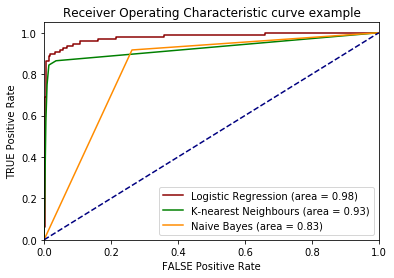

In [106]:
plt.figure()
plt.plot(cfpr, ctpr, color='darkred',lw=LW, label='Logistic Regression (area = %0.2f)' % cAUC)
plt.plot(kfpr, ktpr, color='green',lw=LW, label='K-nearest Neighbours (area = %0.2f)' % kAUC)
plt.plot(nfpr, ntpr, color='darkorange',lw=LW, label='Naive Bayes (area = %0.2f)' % nAUC)
plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--') # reference line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FALSE Positive Rate')
plt.ylabel('TRUE Positive Rate')
plt.title('Receiver Operating Characteristic curve example')
plt.legend(loc=LL)
plt.show()